This notebook provides alignment, conversion, and analysis of videos using the video2vision pipeline. It is intended to walk you through all the steps of using the system. The first cell contains a variety of parameters that set behavior for the rest of the notebook, with each parameter explained in comments:

In [1]:
import json
import os

import video2vision as v2v
import matplotlib.pyplot as plot
import numpy as np
from PIL import Image
from scipy.interpolate import interp1d
from tabulate import tabulate

import widgets

# EXPERIMENT_NAME is used to serialize the current state of the notebook so it can be restored later. Set this
# to None if you don't want that to occur.
EXPERIMENT_NAME = None
# All paths for imagery are relative to the ROOT_PATH.
ROOT_PATH = '../../v2v-data/'
# Path to the pipeline used to perform alignment. An example pipeline is provided in the data folder of the
# GitHub repo, but this may need to be customized for your camera.
ALIGN_PIPELINE_PATH = '../data/still_alignment_pipeline.json'
# Path to saved imagery from the visible-light camera. This can be a path to a specific file, a path to a
# directory containing images, or a path with a wildcard, e.g. '/VIS/*.JPG'.
VIS_PATH = os.path.join(ROOT_PATH, 'VIS/VIS04469.JPG')
# Path to saved imagery from the ultraviolet camera. This can be a path to a specific file, a path to a
# directory containing images, or a path with a wildcard, e.g. '/VIS/*.JPG'.
UV_PATH = os.path.join(ROOT_PATH, 'UV/UV_04374.JPG')
# Path to write aligned ultraviolet images to.
UV_ALIGNED_PATH = os.path.join(ROOT_PATH, 'UV_aligned/')

# If you are using the Sony camera, we can use the SLOG transform so we only need to equalize, not linearize,
# because there is a known relationship between the JPG and RAW values.
IS_SONY_CAMERA = True
# Path to visual image/video used to calculate linearization coefficients. This should be an image or video
# containing samples of known reflectivity.
VIS_LINEARIZATION_SAMPLES_PATH = os.path.join(ROOT_PATH, 'VIS/VIS04467.JPG')
# Path to ultraviolet image/video used to calculate linearization coefficients. This should be an image or video
# containing samples of known reflectivity.
UV_LINEARIZATION_SAMPLES_PATH = os.path.join(ROOT_PATH, 'UV/UV_04372.JPG')
# Path to a saved AutoLinearize operator that can be used to automatically locate the samples in the images used
# for the linearization. This can be set to None if this is not available.
LINEARIZATION_AUTO_OP_PATH = '../data/autolinearizer.json'
# Path to the reflectances of the samples used for the linearization.
LINEARIZATION_VALUES_PATH = '../data/aruco_samples.csv'
# Size, in pixels, of the samples used to calculate the linearization coefficients.
LINEARIZATION_SAMPLE_SIZE = 50

# Path to visual image/video used to estimate error in the linearization. This should be an image or video
# containing samples of known reflectivity. Different samples should generally be used for linearizing and
# estimating linearization error.
VIS_TEST_SAMPLES_PATH = VIS_LINEARIZATION_SAMPLES_PATH
# Path to ultraviolet image/video used to estimate error in the linearization. This should be an image or video
# containing samples of known reflectivity. Different samples should generally be used for linearizing and
# estimating linearization error.
UV_TEST_SAMPLES_PATH = UV_LINEARIZATION_SAMPLES_PATH
# Path to a saved AutoLinearize operator that can be used to automatically locate the samples in the images used
# for estimating linearization error. This can be set to None if this is not available.
TEST_AUTO_OP_PATH = None
# Path to the reflectances of the samples used for the estimation of the error of the linearization.
TEST_SAMPLES_VALUES_PATH = '../data/spectralon_samples.csv'
# Size, in pixels, of the samples used to estimate the error.
TEST_SAMPLE_SIZE = 50

# Path to file containing sensitivities of the camera.
CAMERA_SENSE_PATH = '../data/camera_sensitivities.csv'
# Path to file containing sensitivities of the organism's photoreceptors.
ANIMAL_SENSE_PATH = '../data/animal_sensitivities/avian_sensitivities.csv'
# Path to saved animal sense converter
SENSE_CONVERTER_PATH = '../data/converters/avian_converter.json'
# Path to write converted outputs to.
ANIMAL_OUT_PATH = os.path.join(ROOT_PATH, 'avian')
# Path to write linearized outputs to.
HUMAN_OUT_PATH = os.path.join(ROOT_PATH, 'human')

# How many images to process at a time. This should be as large as will fit into memory.
BATCH_SIZE = 16

if EXPERIMENT_NAME is not None:
    os.makedirs(EXPERIMENT_NAME, exist_ok=True)

We begin by running the alignment. This will take a while if it hasn't been previously run. The alignment operator will be cached when the alignment is finished running, and a report of how long each operator took to run will be printed.

In [2]:
# Load the cached alignment pipeline if available
align_pipe = None
if EXPERIMENT_NAME is not None:
    align_pipe_path = os.path.join(EXPERIMENT_NAME, 'align_pipe.json')
    if os.path.exists(align_pipe_path):
        align_pipe = v2v.load_pipeline(align_pipe_path)

# Run alignment pipeline if not run previously
if align_pipe is None:
    align_pipe = v2v.load_pipeline(ALIGN_PIPELINE_PATH)
    align_pipe.set_all_paths(UV_PATH, VIS_PATH, UV_ALIGNED_PATH)
    align_pipe.set_batch_size(BATCH_SIZE)
    rtn = align_pipe.run()
    print(tabulate(rtn.items()))
    if EXPERIMENT_NAME is not None:
        align_pipe.save(align_pipe_path)

# Extract time shift
align_idx = next(i for i in align_pipe.nodes
         if isinstance(align_pipe.nodes[i]['operator'], v2v.AutoAlign))
align_op = align_pipe.nodes[align_idx]['operator']

if isinstance(align_op, v2v.AutoTemporalAlign):
    shift = align_pipe.nodes[align_idx]['operator'].time_shift
    # Turn time shift off, since we will handle the shift manually in succeeding cells
    align_pipe.nodes[align_idx]['operator'].time_shift = 0
    # Clear the buffer
    align_pipe.nodes[align_idx]['operator'].buff = None
    align_pipe.nodes[align_idx]['operator'].buff_names = None
    print(f'Time Shift: {shift}')

else:
    shift = 0
    print(f'Time Shift: N/A')

---------  ----------
Loader      1.07322
Warp        0.396176
AutoAlign  60.5382
Writer      1.92246
pipeline    0.0229476
---------  ----------
Time Shift: N/A


With the alignment run, let's visualize some of the images to make sure everything looks good. The left image is the image from the visible camera, the right image is the image from the ultraviolet camera, and the middle image is the image from the ultraviolet camera aligned to the visible image. The buttons below the display allow moving forward and backward in time in a video.

In [3]:
image_size = align_pipe.get_loaders()[0].expected_size
vis_reader = v2v.Loader(VIS_PATH, image_size)
uv_aligned_reader = v2v.Loader(UV_ALIGNED_PATH, image_size)
uv_reader = v2v.Loader(UV_PATH, image_size)

uv_shift, vis_shift = max(shift, 0), max(-shift, 0)
video_display = widgets.DisplayBox(vis_reader, uv_aligned_reader, uv_reader, shifts=(uv_shift, 0, 0))
display(video_display)

DisplayBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00FP\x00\x00\r0\x08\x02\x00\x00\x0…

It can be hard to tell from a side-by-side display how accurately two images are aligned. This next cell displays a composite image formed by using the red and blue channels from the visible image, and the green channel from the aligned ultraviolet image. If the alignment is inaccurate, there should be visible "ghosting" caused by objects not perfectly overlaying each other.

In [4]:
ghost_box = widgets.GhostBox(vis_reader, uv_aligned_reader, 0, shifts=(uv_shift, 0))
display(ghost_box)

GhostBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x17p\x00\x00\r0\x08\x02\x00\x00\x…

Now we need to select the samples for linearization. If the autolinearizer is available, this will be done automatically using the fiducial markers. If not, you will need to select the sample points manually by clicking on the image. You can remove a marker by clicking a second time in the same place. It can take a moment for the image to update when you click. Make sure that the samples are selected in the same order that they are listed in the csv with reflectance values. Once this notebook has been run once, the locations of the sample points will be cached, so that they can be reused next time you run this.

In [5]:
uv_line_shift = uv_shift if (VIS_LINEARIZATION_SAMPLES_PATH == VIS_PATH) else 0
vis_line_shift = vis_shift if (VIS_LINEARIZATION_SAMPLES_PATH == VIS_PATH) else 0
vis_linearization_reader = v2v.Loader(VIS_LINEARIZATION_SAMPLES_PATH, image_size)
vis_linearization_selector = widgets.SelectorBox(
    vis_linearization_reader, uv_line_shift,
    LINEARIZATION_SAMPLE_SIZE, box_color=(0, 255, 255),
    auto_op=LINEARIZATION_AUTO_OP_PATH
)

if EXPERIMENT_NAME is not None:
    vis_line_crosshair_path = os.path.join(EXPERIMENT_NAME, 'vis_line_crosshairs.json')
    if os.path.exists(vis_line_crosshair_path):
        vis_linearization_selector.load_crosshairs(vis_line_crosshair_path)

display(vis_linearization_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

The selections will be automatically transferred to the ultraviolet image using the alignment operation. Check to make sure they look right, and correct if necessary before continuing.

In [6]:
uv_linearization_reader = v2v.Loader(UV_LINEARIZATION_SAMPLES_PATH, image_size)
uv_linearization_selector = widgets.SelectorBox(
    uv_linearization_reader,
    (vis_linearization_selector.t - uv_line_shift + vis_line_shift),
    LINEARIZATION_SAMPLE_SIZE,
    preprocess=(lambda x: align_pipe(x, np.empty_like(x))),
    auto_op=LINEARIZATION_AUTO_OP_PATH, box_color=(0, 255, 255)
)

if align_pipe is not None:
    uv_linearization_selector.selector.idxs = vis_linearization_selector.selector.idxs
    uv_linearization_selector.selector.crosshair_type = vis_linearization_selector.selector.crosshair_type
    uv_linearization_selector.selector.crosshairs = vis_linearization_selector.selector.crosshairs

if EXPERIMENT_NAME is not None:
    uv_line_crosshair_path = os.path.join(EXPERIMENT_NAME, 'uv_line_crosshairs.json')
    if os.path.exists(uv_line_crosshair_path):
        uv_linearization_selector.load_crosshairs(uv_line_crosshair_path)

display(uv_linearization_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

We next extract the pixel intensities from each sample point.

In [7]:
vis_line_samples, vis_sample_drop = vis_linearization_selector.get_samples()
uv_line_samples, uv_sample_drop = uv_linearization_selector.get_samples()
if (vis_sample_drop != uv_sample_drop).any():
    raise ValueError('Selection mismatch between VIS and UV')

linearization_samples = np.concatenate((uv_line_samples[:, 2:], vis_line_samples), axis=1)
linearization_samples = linearization_samples[~vis_sample_drop]

if EXPERIMENT_NAME is not None:
    vis_linearization_selector.save_crosshairs(vis_line_crosshair_path)
    uv_linearization_selector.save_crosshairs(uv_line_crosshair_path)

wavelengths = np.arange(300, 701)
linearization_irrad = np.ones((401, 1))

We now build the linearizer.

In [8]:
# Load data to calculate expected values
linearization_sample_ref = np.genfromtxt(LINEARIZATION_VALUES_PATH, skip_header=True, delimiter=',')[:, 1:]
linearization_sample_ref = linearization_sample_ref[:, ~vis_sample_drop]
# Coerce to percentage. There's some error here, resulting in reflectivities that sometimes exceed 100%.
if linearization_sample_ref.max() > 2:
    linearization_sample_ref /= 100
camera_sense = np.genfromtxt(CAMERA_SENSE_PATH, skip_header=True, delimiter=',')[:, 1:]
linearization_expected_values = (linearization_sample_ref * linearization_irrad.reshape(401, 1)).T.dot(camera_sense)

In [9]:
if IS_SONY_CAMERA:
    line_op = v2v.PowerLaw([
        [0.0047058172145495476, 4185.031519941784, -0.01, 0.16736099187966763],
        [0.0047058172145495476, 4185.031519941784, -0.01, 0.16736099187966763],
        [0.0047058172145495476, 4185.031519941784, -0.01, 0.16736099187966763],
        [0.0047058172145495476, 4185.031519941784, -0.01, 0.16736099187966763],
    ])
    linearized_sample_values = line_op.apply_values(linearization_samples)
    for band in range(4):
        scale = float(np.linalg.lstsq(
            linearized_sample_values[:, [band]],
            linearization_expected_values[:, [band]],
            rcond=None
        )[0])
        line_op.funcs[band].scale *= scale
        line_op.funcs[band].shift *= scale

else:
    line_op = v2v.build_linearizer(
        linearization_samples, linearization_expected_values, method='power'
    )

linearized_sample_values = line_op.apply_values(linearization_samples)

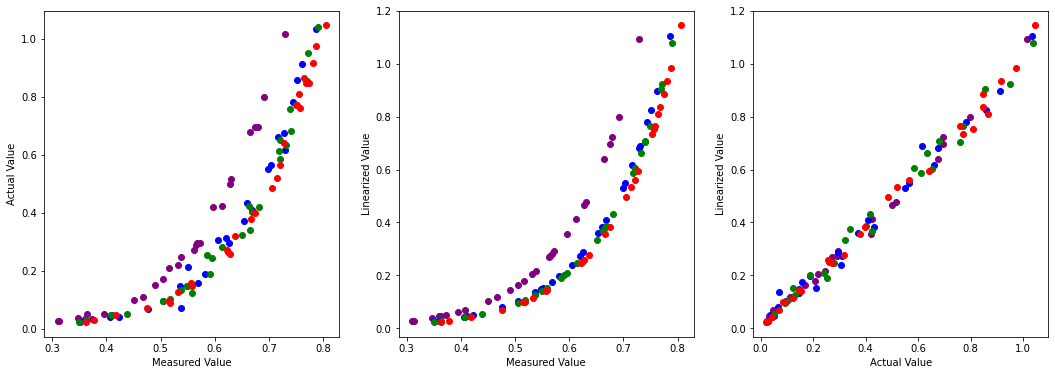

Color          MAE        R2      SNR
-------  ---------  --------  -------
UV       0.0180114  0.990762  353.97
Blue     0.0236989  0.987102  205.898
Green    0.0238744  0.98978   258.337
Red      0.0207255  0.991494  253.507


In [10]:
table = []

plot.figure(figsize=(18, 6))
plot.subplot(1, 3, 3)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        linearization_expected_values[:, band],
        linearized_sample_values[:, band],
        label=band_name,
        color=color,
    )
    ss_res = ((linearization_expected_values[:, band] - linearized_sample_values[:, band])**2).sum()
    ss_tot = ((linearization_expected_values[:, band] - linearization_expected_values[:, band].mean())**2).sum()
    noise = (linearization_expected_values[:, band] - linearized_sample_values[:, band])
    mae = np.abs(noise).mean()
    snr = (linearization_expected_values**2).mean() / (noise**2).mean()
    table.append((band_name, mae, 1 - (ss_res / ss_tot), snr))
plot.xlabel('Actual Value')
plot.ylabel('Linearized Value')

plot.subplot(1, 3, 2)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        linearization_samples[:, band],
        linearized_sample_values[:, band],
        label=band_name,
        color=color,
    )

plot.xlabel('Measured Value')
plot.ylabel('Linearized Value')

plot.subplot(1, 3, 1)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        linearization_samples[:, band],
        linearization_expected_values[:, band],
        label=band_name,
        color=color,
    )

plot.xlabel('Measured Value')
plot.ylabel('Actual Value')

plot.show()

print(tabulate(table, headers=['Color', 'MAE', 'R2', 'SNR']))

Let's run an image through the linearizer to see what it looks like.

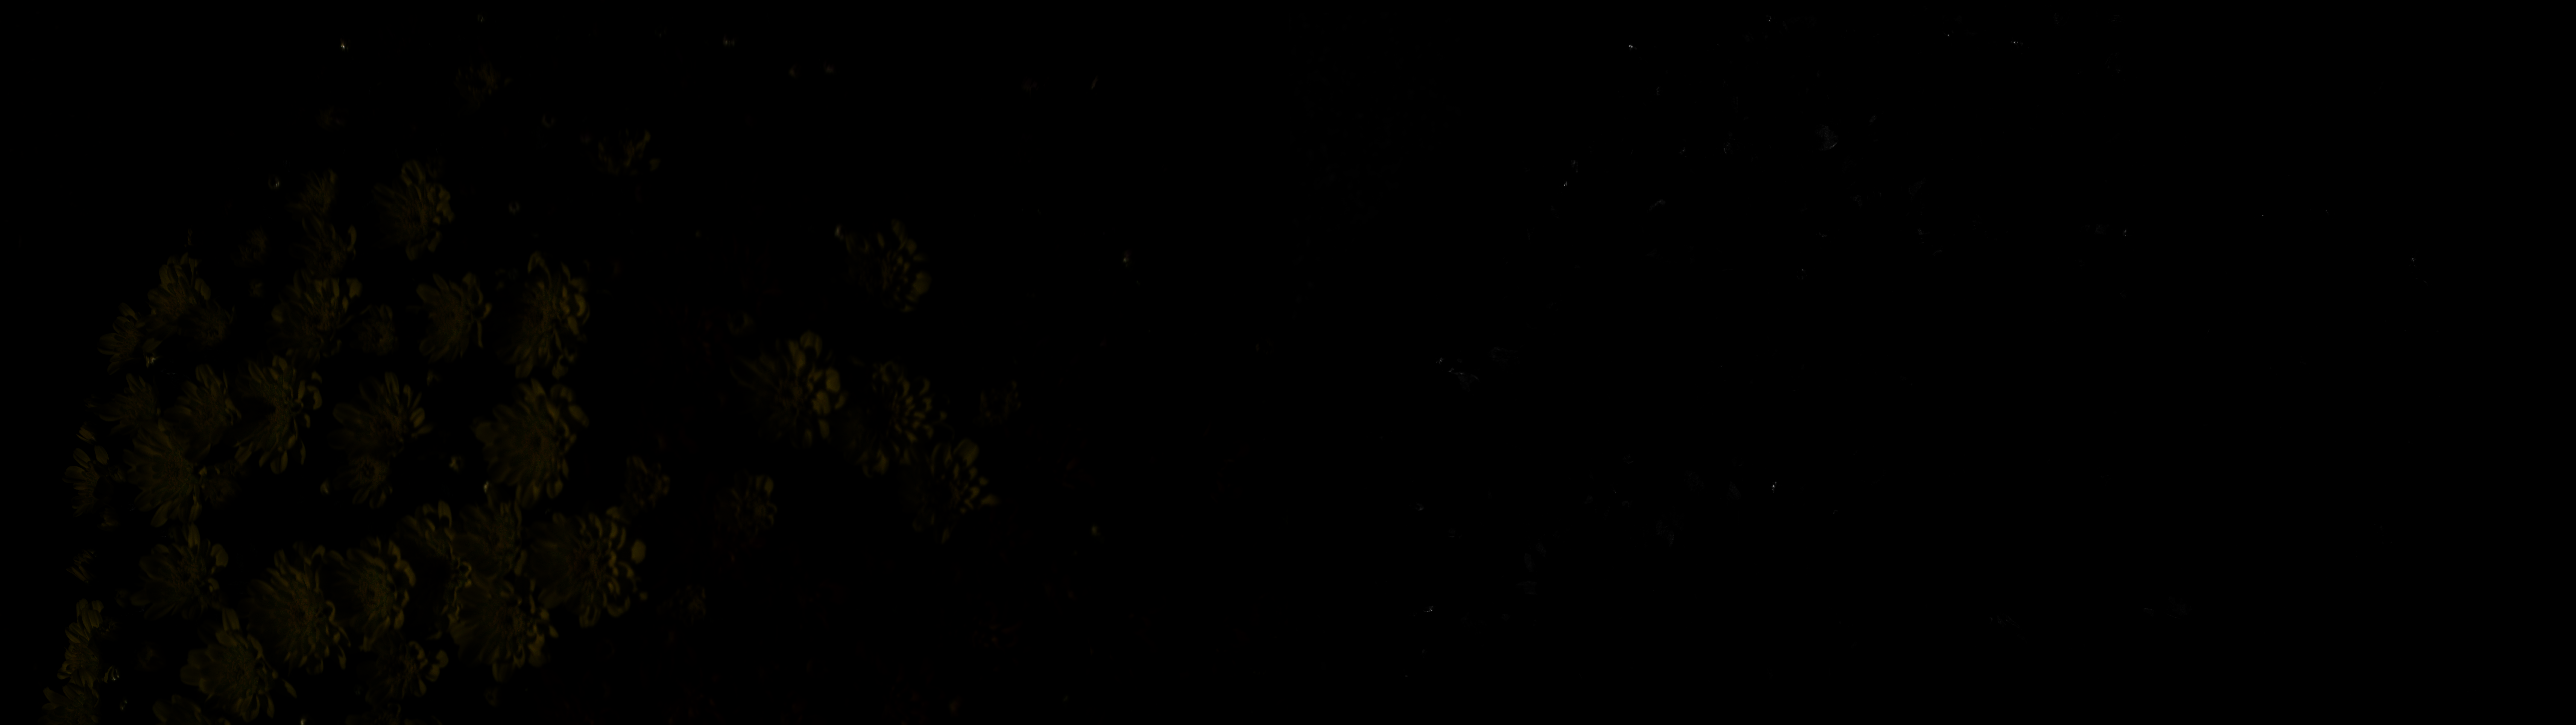

In [11]:
# First, edit the align_pipe to incorporate linearization.
# This is a temporary solution to create a deep copy since Pipeline.copy
# is a shallow copy, and deepcopy(Pipeline) doesn't work.
line_pipe = v2v.load_pipeline(ALIGN_PIPELINE_PATH)
line_pipe.nodes[align_idx]['operator'].coe = align_pipe.nodes[align_idx]['operator'].coe
line_pipe.nodes[align_idx]['operator'].output_size = align_pipe.nodes[align_idx]['operator'].output_size
# Change autoalign to retain both UV and VIS bands
line_pipe.nodes[align_idx]['operator']._concatenate.bands = [[2], [0, 1, 2]]
# Add linearizer to the pipeline
line_idx = line_pipe.add_operator(line_op)
# Change align_op -> writer to align_op -> line_op -> writer.
write_idx = next(i for i in line_pipe.nodes
                 if isinstance(line_pipe.nodes[i]['operator'], v2v.Writer))
line_pipe.remove_edge(align_idx, write_idx)
line_pipe.add_edge(align_idx, line_idx, in_slot=0)
line_pipe.add_edge(line_idx, write_idx, in_slot=0)

# We handle the time shift below by using different frames from the loaders, not by having
# the AutoTemporalAlign handle it
line_pipe.nodes[align_idx]['operator'].time_shift = 0

# Next, run some images through the pipeline.
line_image = line_pipe(uv_reader.get_frame(vis_shift), vis_reader.get_frame(uv_shift))
line_image = widgets.gamma_scale(line_image)
uv_line_image = line_image[..., :1]
vis_line_image = line_image[..., 1:]

# And display separately.
uv_line_image = np.clip(256 * uv_line_image, 0, 255).astype(np.uint8)
vis_line_image = np.clip(256 * vis_line_image, 0, 255).astype(np.uint8)
h, w, _ = vis_line_image.shape
display_image = Image.new('RGB', (2 * w, h))
display_image.paste(Image.fromarray(vis_line_image[..., [2, 1, 0]]), (0, 0))
display_image.paste(Image.fromarray(uv_line_image[..., 0], 'L'), (w, 0))
display(display_image)

We now test the linearizer on another color sample. Once again, select the samples, taking care to keep in order. These next few cells can be skipped if you do not wish to test the linearization error.

In [12]:
vis_test_samples_reader = v2v.Loader(VIS_TEST_SAMPLES_PATH, image_size)
uv_test_samples_reader = v2v.Loader(UV_TEST_SAMPLES_PATH, image_size)

vis_test_samples_selector = widgets.SelectorBox(
    vis_test_samples_reader, uv_shift, TEST_SAMPLE_SIZE, box_color=(0, 255, 255),
    auto_op=TEST_AUTO_OP_PATH,
)

if EXPERIMENT_NAME is not None:
    vis_test_crosshair_path = os.path.join(EXPERIMENT_NAME, 'vis_test_crosshairs.json')
    if os.path.exists(vis_test_crosshair_path):
        vis_test_samples_selector.load_crosshairs(vis_test_crosshair_path)

display(vis_test_samples_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

In [13]:
uv_test_samples_selector = widgets.SelectorBox(
    uv_test_samples_reader, vis_test_samples_selector.t - uv_shift + vis_shift, TEST_SAMPLE_SIZE,
    box_color=(0, 255, 255), preprocess=lambda x: align_pipe(x, np.empty_like(x)),
    auto_op=TEST_AUTO_OP_PATH,
)

uv_test_samples_selector.selector.idxs = vis_test_samples_selector.selector.idxs
uv_test_samples_selector.selector.crosshair_type = vis_test_samples_selector.selector.crosshair_type
uv_test_samples_selector.selector.crosshairs = vis_test_samples_selector.selector.crosshairs

if EXPERIMENT_NAME is not None:
    uv_test_crosshair_path = os.path.join(EXPERIMENT_NAME, 'uv_test_crosshairs.json')
    if os.path.exists(uv_test_crosshair_path):
        uv_test_samples_selector.load_crosshairs(uv_test_crosshair_path)

display(uv_test_samples_selector)

SelectorBox(children=(SampleSelector(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x06\xf1\x00\x00\x03\x…

In [14]:
# Load data to calculate expected values
test_sample_ref = np.genfromtxt(TEST_SAMPLES_VALUES_PATH, skip_header=True, delimiter=',')[:, 1:]
# Coerce to percentage. There's some error here, resulting in reflectivities that sometimes exceed 100%.
if test_sample_ref.max() > 2:
    test_sample_ref /= 100
# Get the illuminance
test_irrad = np.ones((401, 1))
test_samples_expected_values = (test_sample_ref * test_irrad.reshape(401, 1)).T.dot(camera_sense)

vis_test_samples, vis_sample_drop = vis_test_samples_selector.get_samples()
uv_test_samples, uv_sample_drop = uv_test_samples_selector.get_samples()
if (vis_sample_drop != uv_sample_drop).any():
    raise ValueError('Selection mismatch between VIS and UV')

test_samples = np.concatenate((uv_test_samples[:, 2:], vis_test_samples), axis=1)
test_samples = test_samples[~vis_sample_drop]
test_sample_ref = test_sample_ref[:, ~vis_sample_drop]
test_samples_expected_values = test_samples_expected_values[~vis_sample_drop]

if EXPERIMENT_NAME is not None:
    vis_test_samples_selector.save_crosshairs(vis_test_crosshair_path)
    uv_test_samples_selector.save_crosshairs(uv_test_crosshair_path)

test_samples_linearized_values = line_op.apply_values(test_samples)

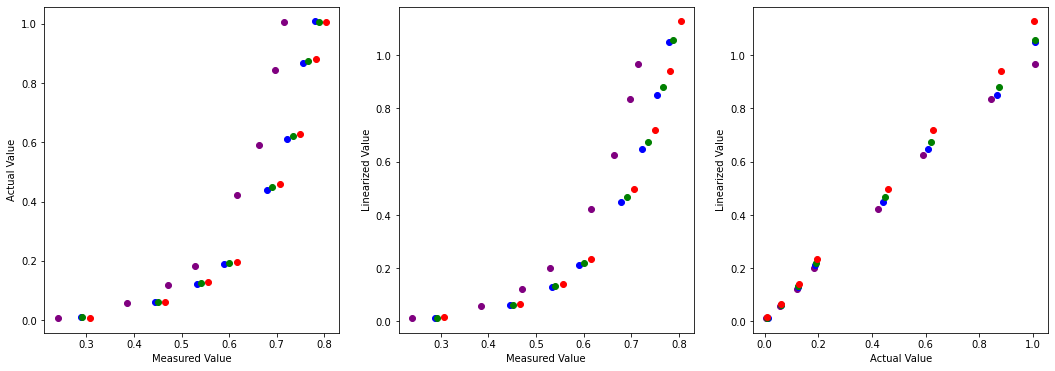

Color          MAE        R2       SNR
-------  ---------  --------  --------
UV       0.0139809  0.996719  703.366
Blue     0.0172525  0.995996  585.688
Green    0.0208496  0.993664  372.715
Red      0.0462778  0.971213   82.4769


In [15]:
table = []

plot.figure(figsize=(18, 6))
plot.subplot(1, 3, 3)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        test_samples_expected_values[:, band],
        test_samples_linearized_values[:, band],
        label=band_name,
        color=color,
    )
    ss_res = ((test_samples_expected_values[:, band] - test_samples_linearized_values[:, band])**2).sum()
    ss_tot = ((test_samples_expected_values[:, band] - test_samples_expected_values[:, band].mean())**2).sum()
    noise = test_samples_expected_values[:, band] - test_samples_linearized_values[:, band]
    mae = np.abs(noise).mean()
    snr = ((test_samples_expected_values[:, band])**2).mean() / (noise**2).mean()
    table.append((band_name, mae, 1 - (ss_res / ss_tot), snr))

plot.xlabel('Actual Value')
plot.ylabel('Linearized Value')

plot.subplot(1, 3, 2)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        test_samples[:, band], #[idxs, band],
        test_samples_linearized_values[:, band],
        label=band_name,
        color=color,
    )

plot.xlabel('Measured Value')
plot.ylabel('Linearized Value')

plot.subplot(1, 3, 1)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.scatter(
        test_samples[:, band], #[idxs, band],
        test_samples_expected_values[:, band],
        label=band_name,
        color=color,
    )

plot.xlabel('Measured Value')
plot.ylabel('Actual Value')

plot.show()

print(tabulate(table, headers=['Color', 'MAE', 'R2', 'SNR']))

Next, we construct the operator to convert linearized camera values to animal values.

In [16]:
# Load animal sensitivities
animal_sense = np.genfromtxt(ANIMAL_SENSE_PATH, skip_header=True, delimiter=',')[:, 1:]
sense_converter = v2v.load_operator(SENSE_CONVERTER_PATH)

We visualize the sensitivity of the camera and the animal's photoreceptors.

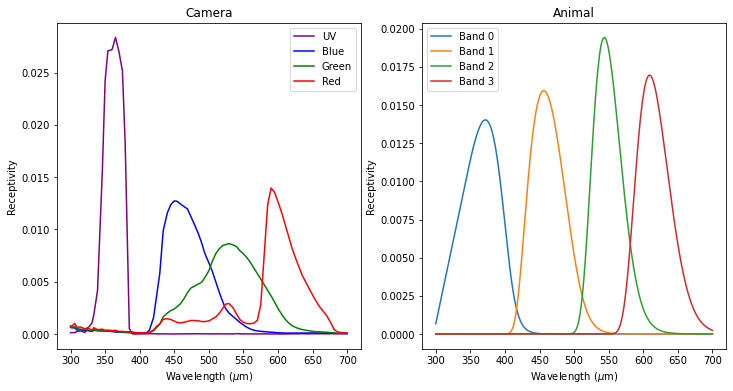

In [17]:
plot.figure(figsize=(12, 6))

plot.subplot(1, 2, 1)
for band, band_name in enumerate(['UV', 'Blue', 'Green', 'Red']):
    color = (band_name[0].lower() if band_name != 'UV' else 'purple')
    plot.plot(
        np.arange(300, 701),
        camera_sense[:, band],
        color=color,
        label=band_name,
    )
plot.xlabel('Wavelength ($\mu$m)')
plot.ylabel('Receptivity')
plot.title('Camera')
plot.legend()

plot.subplot(1, 2, 2)
for band in range(animal_sense.shape[1]):
    plot.plot(
        np.arange(300, 701),
        animal_sense[:, band],
        label=f'Band {band}',
    )
plot.xlabel('Wavelength ($\mu$m)')
plot.ylabel('Receptivity')
plot.title('Animal')
plot.legend()

plot.show()

Finally, we estimate the error on the test samples. Skip this cell if you did not provide test samples.

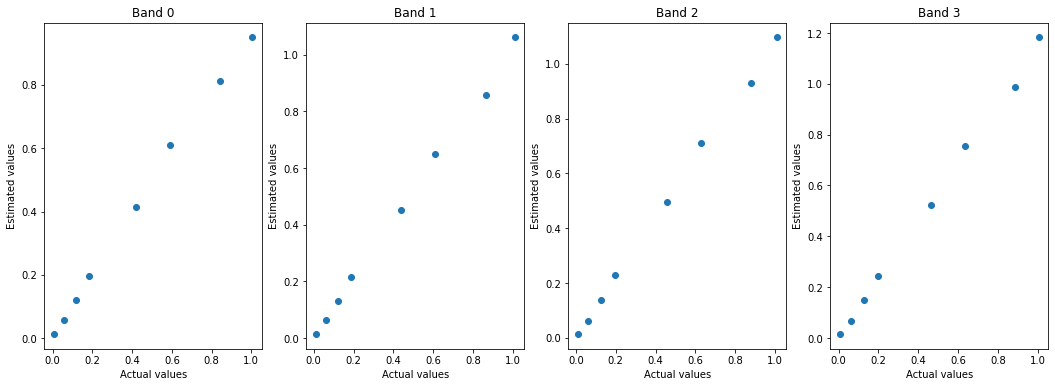

  Band        MAE        R2
------  ---------  --------
     0  0.017339   0.99516
     1  0.0193714  0.994523
     2  0.0396671  0.979428
     3  0.0661974  0.941073


In [18]:
predicted_values = test_samples_linearized_values.dot(sense_converter.mat)
expected_values = test_sample_ref.T.dot(animal_sense)

table = []

plot.figure(figsize=(18, 6))
for band in range(animal_sense.shape[1]):
    plot.subplot(1, animal_sense.shape[1], band + 1)
    plot.title(f'Band {band}')
    plot.scatter(
        expected_values[:, band],
        predicted_values[:, band],
    )

    ss_res = ((expected_values[:, band] - predicted_values[:, band])**2).sum()
    ss_tot = ((expected_values[:, band] - expected_values[:, band].mean())**2).sum()
    mae = np.abs(expected_values[:, band] - predicted_values[:, band]).mean()
    table.append((band, mae, 1 - (ss_res / ss_tot)))
    plot.xlabel('Actual values')
    plot.ylabel('Estimated values')

plot.show()

print(tabulate(table, headers=['Band', 'MAE', 'R2']))

We now construct a pipeline that linearizes and converts the aligned images, and run it. This will take a while.

In [19]:
# Construct the pipeline from scratch in case this cell is rerun
full_pipe = v2v.load_pipeline(ALIGN_PIPELINE_PATH)
# Copy alignment information in
full_pipe.nodes[align_idx]['operator'].coe = align_pipe.nodes[align_idx]['operator'].coe
full_pipe.nodes[align_idx]['operator'].output_size = align_pipe.nodes[align_idx]['operator'].output_size
if isinstance(full_pipe.nodes[align_idx]['operator'], v2v.AutoTemporalAlign):
    full_pipe.nodes[align_idx]['operator'].time_shift = align_pipe.nodes[align_idx]['operator'].time_shift
# Change autoalign to retain both UV and VIS bands
full_pipe.nodes[align_idx]['operator']._concatenate.bands = [[2], [0, 1, 2]]
# Add linearizer to the pipeline
line_idx = full_pipe.add_operator(line_op)
# Change align_op -> writer to align_op -> line_op -> sense_converter -> writer.
write_idx = next(i for i in full_pipe.nodes
                 if isinstance(full_pipe.nodes[i]['operator'], v2v.Writer))
full_pipe.remove_edge(align_idx, write_idx)
full_pipe.add_edge(align_idx, line_idx, in_slot=0)
sense_idx = full_pipe.add_operator(sense_converter)
full_pipe.add_edge(line_idx, sense_idx, in_slot=0)
full_pipe.add_edge(sense_idx, write_idx, in_slot=0)
# Add second writer to capture linearized outputs
write_2_idx = full_pipe.add_operator(v2v.Writer(extension=full_pipe.nodes[write_idx]['operator'].extension))
sel_idx = full_pipe.add_operator(v2v.ConcatenateOnBands([[1, 2, 3]]))
full_pipe.add_edge(line_idx, sel_idx, in_slot=0)
full_pipe.add_edge(sel_idx, write_2_idx, in_slot=0)

if animal_sense.shape[1] != 3:
    full_pipe.nodes[write_idx]['operator'].separate_bands = True

full_pipe.set_batch_size(BATCH_SIZE // 2)

full_pipe.set_all_paths(UV_PATH, VIS_PATH, ANIMAL_OUT_PATH, HUMAN_OUT_PATH)
rtn = full_pipe.run()

print(tabulate(rtn.items()))

------------------  ---------
Loader              1.04484
Warp                0.758884
AutoAlign           2.0383
PowerLaw            1.63753
LinearMap           2.36949
ConcatenateOnBands  0.747861
Writer              2.90938
pipeline            0.0238978
------------------  ---------


Let's take a look at the results:

In [20]:
if animal_sense.shape[1] == 3:
    animal_readers = [v2v.Loader(ANIMAL_OUT_PATH, image_size)]
    preprocess = None
elif animal_sense.shape[1] == 4:
    animal_readers = [
        v2v.Loader(os.path.join(ANIMAL_OUT_PATH, f'*_{band}.*'), image_size,
                   num_channels=1)
        for band in range(4)
    ]
    preprocess = lambda u, b, g, r, h: (np.concatenate((0.5 * (u + b), g, r), axis=-1), h[..., 0])

human_reader = v2v.Loader(HUMAN_OUT_PATH, image_size)
animal_display = widgets.DisplayBox(*animal_readers, human_reader, preprocess=preprocess)
display(animal_display)

DisplayBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00.\xe0\x00\x00\r0\x08\x02\x00\x00…